In [ ]:
#!pip install "cut-cross-entropy @ git+https://github.com/apple/ml-cross-entropy.git"

# Обучение и тестирование модели SaSRec с лоссами CE и CCE на датасете Beauty

### 1. Импорты

In [ ]:
import os

project_path = '/content/drive/MyDrive/CutCrossEntropy'
os.chdir(project_path)

In [ ]:
import torch
import pandas as pd

from src.model import SASRec
from src.train import run_training
from src.dataset import prepare_data, build_dataset, SASRecDataset
from src.evaluate import evaluate
from src.metrics import Metrics
from src.utils import plot_loss

In [ ]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s'
)

logger = logging.getLogger(__name__)

In [ ]:
!nvidia-smi

Wed Jul 30 22:03:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 2. Обработка и подготовка данных

Датасет Beauty

In [ ]:
path_dataset = 'data/Beauty_and_Personal_Care.csv'
df = pd.read_csv(path_dataset)

df = df[['user_id','parent_asin','timestamp']]
df.columns = ['user_id', 'item_id', 'datetime']

df.shape

(6624441, 3)

In [ ]:
max_len = 50 #512
batch_size = 256
logger.info(f'Maximum sequence length = {max_len}, batch size = {batch_size}')
# Загрузка
user_seqs, num_users, num_items, _, _ = prepare_data(df, min_user_inter=3, min_item_inter=3)

# Сплиты
train_data, val_data, test_data = build_dataset(user_seqs, max_len=max_len)

# Dataset и DataLoader
train_dataset = SASRecDataset(train_data, max_len=max_len, num_items=num_items)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SASRecDataset(val_data, max_len=max_len, num_items=num_items)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SASRecDataset(test_data, max_len=max_len, num_items=num_items)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Пример
for batch in train_loader:
    _, seqs, targets = batch
    print("Seqs:", seqs.shape)       # [B, T]
    print("Targets:", targets.shape) # [B]
    break

2025-07-30 22:03:55,202 [INFO] Maximum sequence length = 50, batch size = 256
2025-07-30 22:03:55,203 [INFO] Filter users with interactions < 3 and items with interactions < 3
2025-07-30 22:04:00,759 [INFO] Encoding
2025-07-30 22:04:09,113 [INFO] N users: 729576, N items: 207649
2025-07-30 22:04:09,114 [INFO] Groupping


Seqs: torch.Size([256, 49])
Targets: torch.Size([256])


### 3. Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Обучение на",device)

Обучение на cuda


#### 3.1 CE Loss

In [ ]:
model_ce, res_ce, mem_ce = run_training(
    model_class=SASRec,
    num_items=num_items,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_type='CE',
    device=device,
    n_epochs=5,
    hidden_dim=64,
    max_len=max_len,
    lr=0.001
)


cuda


2025-07-30 22:04:41,604 [INFO] Loss = CE
Epoch 1: 100%|██████████| 2850/2850 [01:47<00:00, 26.50it/s, loss=12.8888]


{'train_loss': 12.8641, 'train_time_s': 107.57, 'val_loss': 11.4656, 'val_time_s': 42.07, 'epoch': 1}


Epoch 2: 100%|██████████| 2850/2850 [01:44<00:00, 27.17it/s, loss=11.0916]


{'train_loss': 11.0904, 'train_time_s': 104.91, 'val_loss': 11.2285, 'val_time_s': 42.19, 'epoch': 2}


Epoch 3: 100%|██████████| 2850/2850 [01:44<00:00, 27.18it/s, loss=10.9300]


{'train_loss': 10.9298, 'train_time_s': 104.86, 'val_loss': 11.2195, 'val_time_s': 45.56, 'epoch': 3}


Epoch 4: 100%|██████████| 2850/2850 [01:46<00:00, 26.79it/s, loss=10.8820]


{'train_loss': 10.8825, 'train_time_s': 106.38, 'val_loss': 11.1904, 'val_time_s': 43.73, 'epoch': 4}


Epoch 5: 100%|██████████| 2850/2850 [01:45<00:00, 27.14it/s, loss=10.8536]
2025-07-30 22:17:05,886 [INFO] Peak GPU memory = 1.0849 GB


{'train_loss': 10.8542, 'train_time_s': 105.01, 'val_loss': 11.1903, 'val_time_s': 42.0, 'epoch': 5}


In [ ]:
res_ce

,train_loss,train_time_s,val_loss,val_time_s,epoch
0,12.8641,107.57,11.4656,42.07,1
1,11.0904,104.91,11.2285,42.19,2
2,10.9298,104.86,11.2195,45.56,3
3,10.8825,106.38,11.1904,43.73,4
4,10.8542,105.01,11.1903,42.00,5


In [ ]:
print(f'Среднее время обучения на одну эпоху = {int(res_ce.train_time_s.mean())} с')
print(f'Максимальная память = {mem_ce} ГБ')

Среднее время обучения на одну эпоху = 105 с
Максимальная память = 1.084890365600586 ГБ


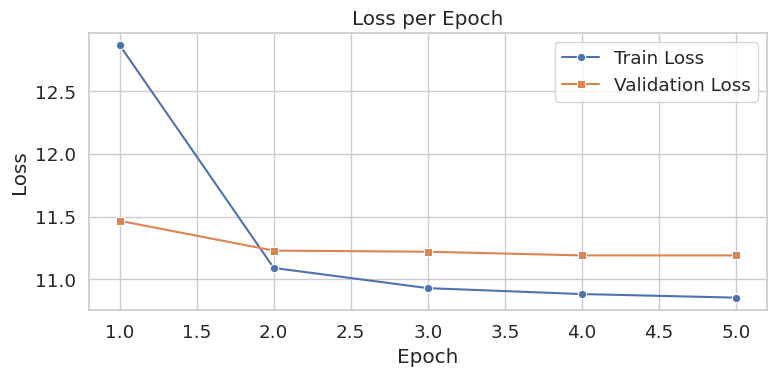

In [ ]:
plot_loss(res_ce)

#### 3.2 CCE Loss

In [ ]:
model_cce, res_cce, mem_cce = run_training(
    model_class=SASRec,
    num_items=num_items,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_type='CCE',
    device=device,
    n_epochs=10,
    hidden_dim=64,
    max_len=max_len,
    lr=0.0001
)

2025-07-30 22:29:29,738 [INFO] Loss = CCE


cuda


Epoch 1: 100%|██████████| 2850/2850 [01:17<00:00, 36.80it/s, loss=21.7449]


{'train_loss': 21.6363, 'train_time_s': 77.45, 'val_loss': 15.0847, 'val_time_s': 33.73, 'epoch': 1}


Epoch 2: 100%|██████████| 2850/2850 [01:20<00:00, 35.39it/s, loss=13.6217]


{'train_loss': 13.6019, 'train_time_s': 80.53, 'val_loss': 12.3554, 'val_time_s': 33.64, 'epoch': 2}


Epoch 3: 100%|██████████| 2850/2850 [01:19<00:00, 35.89it/s, loss=12.1880]


{'train_loss': 12.186, 'train_time_s': 79.41, 'val_loss': 12.0155, 'val_time_s': 32.99, 'epoch': 3}


Epoch 4: 100%|██████████| 2850/2850 [01:18<00:00, 36.34it/s, loss=11.9598]


{'train_loss': 11.9576, 'train_time_s': 78.43, 'val_loss': 11.8198, 'val_time_s': 33.52, 'epoch': 4}


Epoch 5: 100%|██████████| 2850/2850 [01:19<00:00, 35.95it/s, loss=11.7123]


{'train_loss': 11.7107, 'train_time_s': 79.29, 'val_loss': 11.6314, 'val_time_s': 33.63, 'epoch': 5}


Epoch 6: 100%|██████████| 2850/2850 [01:17<00:00, 36.80it/s, loss=11.5370]


{'train_loss': 11.5361, 'train_time_s': 77.45, 'val_loss': 11.5181, 'val_time_s': 33.47, 'epoch': 6}


Epoch 7: 100%|██████████| 2850/2850 [01:16<00:00, 37.22it/s, loss=11.4220]


{'train_loss': 11.4214, 'train_time_s': 76.58, 'val_loss': 11.4369, 'val_time_s': 33.86, 'epoch': 7}


Epoch 8: 100%|██████████| 2850/2850 [01:18<00:00, 36.32it/s, loss=11.3388]


{'train_loss': 11.3385, 'train_time_s': 78.48, 'val_loss': 11.3839, 'val_time_s': 33.33, 'epoch': 8}


Epoch 9: 100%|██████████| 2850/2850 [01:17<00:00, 36.80it/s, loss=11.2762]


{'train_loss': 11.276, 'train_time_s': 77.46, 'val_loss': 11.3507, 'val_time_s': 34.1, 'epoch': 9}


Epoch 10: 100%|██████████| 2850/2850 [01:16<00:00, 37.25it/s, loss=11.2291]
2025-07-30 22:48:07,065 [INFO] Peak GPU memory = 0.7105 GB


{'train_loss': 11.2291, 'train_time_s': 76.51, 'val_loss': 11.3276, 'val_time_s': 33.45, 'epoch': 10}


In [ ]:
res_cce

,train_loss,train_time_s,val_loss,val_time_s,epoch
0,21.6363,77.45,15.0847,33.73,1
1,13.6019,80.53,12.3554,33.64,2
2,12.1860,79.41,12.0155,32.99,3
3,11.9576,78.43,11.8198,33.52,4
4,11.7107,79.29,11.6314,33.63,5
5,11.5361,77.45,11.5181,33.47,6
6,11.4214,76.58,11.4369,33.86,7
7,11.3385,78.48,11.3839,33.33,8
8,11.2760,77.46,11.3507,34.10,9
9,11.2291,76.51,11.3276,33.45,10


In [ ]:
print(f'Среднее время обучения на одну эпоху = {int(res_cce.train_time_s.mean())} с')
print(f'Максимальная память = {mem_cce} ГБ')

Среднее время обучения на одну эпоху = 78 с
Максимальная память = 0.7105245590209961 ГБ


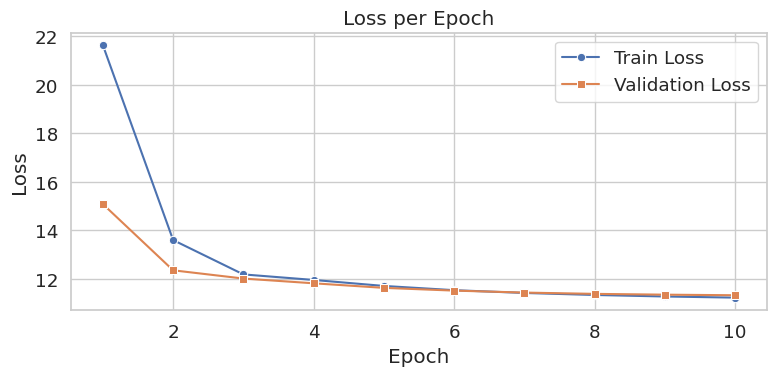

In [ ]:
plot_loss(res_cce)

### 4. Тестирование

#### 4.1 CE Loss

In [ ]:
scores_ce = evaluate(model_ce, test_loader, device)

100%|██████████| 2850/2850 [01:27<00:00, 32.42it/s]


In [ ]:
metrics = Metrics(k=10, train=train_data)
metrics.compute(scores_ce)

{'HitRate@10': 0.009277,
 'NDCG@10': 0.005239,
 'Coverage@10': 0.01083,
 'Surprisal@10': 0.395284}

#### 4.2 CCE Loss

In [ ]:
scores_cce = evaluate(model_cce, test_loader, device)

100%|██████████| 2850/2850 [01:28<00:00, 32.04it/s]


In [ ]:
metrics = Metrics(k=10, train=train_data)
metrics.compute(scores_cce)

{'HitRate@10': 0.009655,
 'NDCG@10': 0.005392,
 'Coverage@10': 0.00013,
 'Surprisal@10': 0.389152}